In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


### Import  libraries


In [2]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

from keras.models import Model
from keras.layers import Input,Dropout, Flatten, Dense,LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam


In [3]:
import zipfile
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/temp/")

with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/temp/")

In [4]:
ROOT = '/kaggle/temp/'
breeds = os.listdir(ROOT + 'Annotation') 
dogs = os.listdir(ROOT + 'all-dogs')

### Import images

In [5]:
idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

for breed in breeds:
    for dog in os.listdir(ROOT+'Annotation/'+breed):
        try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg') 
        except: continue           
        tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            #if idxIn%1000==0: print(idxIn)
            namesIn.append(breed)
            idxIn += 1


### Build dog generator

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 4096)              40964096  
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 256)         409856    
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 128)       819328    
_________________________________________________________________
up_sampling2d_31 (UpSampling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 64)      

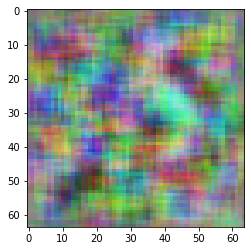

In [173]:

from tensorflow.keras.models import Sequential# function will return a generator model
import tensorflow as tf


generator = Sequential()
generator.add(Dense(64*64, input_shape=(10000,)))

generator.add(Reshape((8, 8, 64)))
generator.add(Conv2D (256, (5, 5), activation='elu', padding='same'))
generator.add(UpSampling2D((2, 2)))

generator.add(Conv2D (128, (5, 5), activation='elu', padding='same'))
generator.add(UpSampling2D((2, 2)))

generator.add(Conv2D (64, (5, 5), activation='elu', padding='same'))
generator.add(UpSampling2D((2, 2)))
#generator.add(BatchNormalization())
#generator.add(LeakyReLU())
generator.add(Conv2D (3, (5, 5),activation='sigmoid', padding='same'))
generator.summary()

#
noise = tf.random.normal([1,10000])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])

generator.compile(optimizer=Adam(lr=0.003), loss='binary_crossentropy')

In [8]:
# TRAINING DATA
idx = np.random.randint(0,idxIn,10000)
train_y = imagesIn[idx,:,:,:]/255.
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1


### Build dog discriminator

In [174]:
# Discriminator function
discriminator = Sequential()
discriminator.add(Conv2D(64, (6, 6), strides=(2, 2), padding='same',
                                 input_shape=[64, 64, 3]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='linear'))

discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 32, 64)        6976      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)           

### Build some funtion to train GAN

In [178]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    #print('         real loss: {}  fake loss: {}'.format(real_loss, fake_loss))
    total_loss = real_loss + fake_loss
    return total_loss


discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

def train_step(images, step_of_epoch=None):
    
    for i in range(5):
        with tf.GradientTape() as gen_tape:

            xx = tf.random.normal([16, 10000])
            generated_images = generator(xx, training=True)
            #print(generated_images.shape)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = generator_loss(fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        

    with tf.GradientTape() as disc_tape:
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=False)

        disc_loss = discriminator_loss(real_output, fake_output)
        
        print('gen loss: {}    disc loss: {}'.format(gen_loss, disc_loss))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [143]:
noise_for_gen = tf.random.normal([16, 10000])

In [176]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))
    #print(predictions.shape)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(((predictions[i, :, :, :]).numpy()*127.5+127.5).astype(int)) 
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [177]:
#import time
import IPython
from IPython import display

def train(dataset, epochs):
    for epoch in range(epochs):
        print('Training epoch {}/{}'.format(epoch, epochs))
        #start = time.time()
    
        i = 0
        for image_batch in dataset:
            #print(.shape)
            
            train_step(np.array([image_batch]))
            i += 1
            if i >= 10:
                break

        # Produce images for a GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 noise_for_gen)

        #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             noise_for_gen)

### Train

In [ ]:
train(train_y, 400)

### See the result


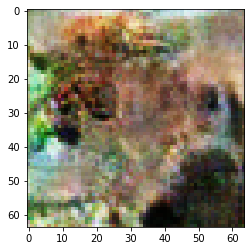

In [182]:
noise = tf.random.normal([1,10000])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])

#### a dog... maybe?
